# AI Text Summarizer

### Import Requirements

In [1]:
# python3 -m venv venv
# source venv/bin/activate

In [2]:
%pip install rouge_score
%pip install evaluate
%pip install --upgrade -q wandb
%pip install --upgrade datasets
%pip install python-dotenv
# %pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cpu
%pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu121
%pip install --upgrade transformers
%pip install --upgrade transformers[torch]
%pip install seaborn
%pip install torch-directml

You should consider upgrading via the '/home/dswamina/ai-text-summarizer/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/dswamina/ai-text-summarizer/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/dswamina/ai-text-summarizer/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/dswamina/ai-text-summarizer/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/dswamina/ai-text-summarizer/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://do

In [3]:
import pandas as pd 
import numpy as np
import os
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline, set_seed
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import AutoTokenizer

import datasets
from datasets import Dataset
from datasets import DatasetDict

from evaluate import load

from tqdm import tqdm

import wandb
import huggingface_hub

import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt_tab")

import warnings
warnings.filterwarnings('ignore')

import evaluate



/home/dswamina/ai-text-summarizer/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     //home/dswamina/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# verifying CUDA is available
print("Torch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available()) # should be true if your graphics card is captable with NVIDIA CUDA
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

Torch Version: 2.4.1+cu121
CUDA Available: True
CUDA Version: 12.1
Number of GPUs: 4
GPU Name: Tesla V100-PCIE-32GB


In [5]:
# Load environment variables from .env file
load_dotenv()

# Retrieve tokens from environment variables
huggingface_token = os.getenv("HUGGINGFACE_TOKEN")
wandb_token = os.getenv("WANDB_API_KEY")





In [6]:
# log in to wandb
wandb.login(key=wandb_token)



wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: //home/dswamina/.netrc
wandb: Currently logged in as: bernicelau (ai-text-summarizer) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
# initializing/creating wandb project 
#os.environ["WANDB_MODE"] = "offline" # TODO: trouble connecting to wandb due to restricting network, so keeping it offline for now
wandb.init(project="ai-text_summmarizer")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [8]:
# log in to Hugging Face Hub
huggingface_hub.login(token=huggingface_token)

In [9]:
# Check if CUDA is available and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"


# Model checkpoint
model_ckpt = "facebook/bart-base"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [10]:
# Data Analysis
dataset_paths = 'bbc-news-dataset'
articles_path = 'news-articles'
summaries_path = 'summaries'

articles = []
summaries = []
file_arr = []



folders = os.listdir(dataset_paths + '/' + articles_path)

for folder in folders:
    files = os.listdir(dataset_paths + '/' + articles_path + '/' + folder)
    for file in files:
        article_file_path = os.path.join(dataset_paths, articles_path, folder, file)
        summary_file_path = os.path.join(dataset_paths, summaries_path, folder, file)

        try:
            with open (article_file_path,'r') as f:
                articles.append('.'.join([line.rstrip() for line in f.readlines()]))
            with open (summary_file_path,'r') as f:
                summaries.append('.'.join([line.rstrip() for line in f.readlines()]))
            file_arr.append(folder + '/' + file)
        except Exception as e:
            print(f"Error reading file {file} with error {e}")

Error reading file 199.txt with error 'utf-8' codec can't decode byte 0xa3 in position 257: invalid start byte


In [11]:
df = pd.DataFrame({'path':file_arr,'article': articles,'summary':summaries})
df.head()

,path,article,summary
0,business/001.txt,Ad sales boost Time Warner profit..Quarterly p...,TimeWarner said fourth quarter sales rose 2% t...
1,business/002.txt,Dollar gains on Greenspan speech..The dollar h...,The dollar has hit its highest level against t...
2,business/003.txt,Yukos unit buyer faces loan claim..The owners ...,Yukos' owner Menatep Group says it will ask Ro...
3,business/004.txt,High fuel prices hit BA's profits..British Air...,"Rod Eddington, BA's chief executive, said the ..."
4,business/005.txt,Pernod takeover talk lifts Domecq..Shares in U...,Pernod has reduced the debt it took on to fund...


In [12]:
# removing nans if any

df.dropna(inplace=True)
df.isnull().sum()

path       0
article    0
summary    0
dtype: int64

In [13]:
# crating function to count the words in each sample

def word_count(sentence):
    sentences = sentence.split()
    return len(sentences)

In [14]:
# creating new columns of word numbers

df['num_words_article'] = df['article'].apply(word_count)
df['num_words_summary'] = df['summary'].apply(word_count)
df.head()

,path,article,summary,num_words_article,num_words_summary
0,business/001.txt,Ad sales boost Time Warner profit..Quarterly p...,TimeWarner said fourth quarter sales rose 2% t...,416,134
1,business/002.txt,Dollar gains on Greenspan speech..The dollar h...,The dollar has hit its highest level against t...,381,158
2,business/003.txt,Yukos unit buyer faces loan claim..The owners ...,Yukos' owner Menatep Group says it will ask Ro...,261,121
3,business/004.txt,High fuel prices hit BA's profits..British Air...,"Rod Eddington, BA's chief executive, said the ...",401,197
4,business/005.txt,Pernod takeover talk lifts Domecq..Shares in U...,Pernod has reduced the debt it took on to fund...,262,106


In [15]:
# getting statistical info about the word lenghths

df.describe()

,num_words_article,num_words_summary
count,2224.000000,2224.000000
mean,379.286871,165.151529
std,235.081995,108.678038
min,87.000000,38.000000
25%,242.000000,103.000000
50%,327.000000,142.000000
75%,465.250000,202.000000
max,4377.000000,2073.000000


Upper whisker: 799.0
Q3: 465.25
Q2: 327.0
Q1: 242.0
Lower whisker: 87.0


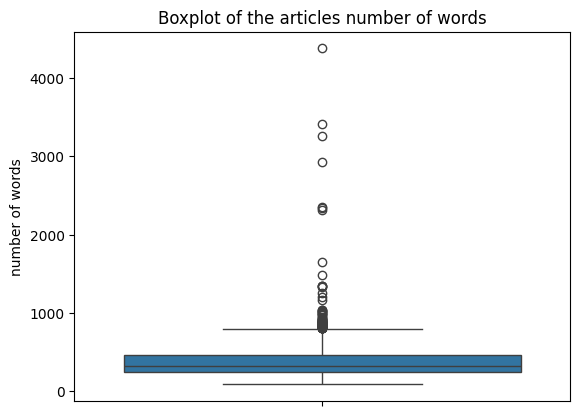

In [16]:
sns.boxplot(df["num_words_article"])
plt.ylabel("number of words")
plt.title("Boxplot of the articles number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1,Q3,article_lower_whisker,article_upper_whisker, Q2 = all_lines

print("Upper whisker:", article_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", article_lower_whisker)

Upper whisker: 350.0
Q3: 202.0
Q2: 142.0
Q1: 103.0
Lower whisker: 38.0


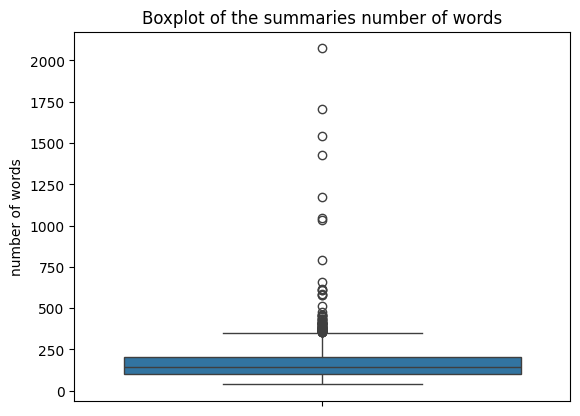

In [17]:
sns.boxplot(df["num_words_summary"])
plt.ylabel("number of words")
plt.title("Boxplot of the summaries number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1,Q3,summary_lower_whisker,summary_upper_whisker, Q2 = all_lines

print("Upper whisker:", summary_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", summary_lower_whisker)

In [18]:
# removing the samples of very long sequences

new_df = df[(df['num_words_summary'] <= summary_upper_whisker) & (df['num_words_article'] <= article_upper_whisker)]
new_df

,path,article,summary,num_words_article,num_words_summary
0,business/001.txt,Ad sales boost Time Warner profit..Quarterly p...,TimeWarner said fourth quarter sales rose 2% t...,416,134
1,business/002.txt,Dollar gains on Greenspan speech..The dollar h...,The dollar has hit its highest level against t...,381,158
2,business/003.txt,Yukos unit buyer faces loan claim..The owners ...,Yukos' owner Menatep Group says it will ask Ro...,261,121
3,business/004.txt,High fuel prices hit BA's profits..British Air...,"Rod Eddington, BA's chief executive, said the ...",401,197
4,business/005.txt,Pernod takeover talk lifts Domecq..Shares in U...,Pernod has reduced the debt it took on to fund...,262,106
...,...,...,...,...,...
2214,tech/392.txt,Broadband fuels online expression..Fast web ac...,More than five million households in the UK ha...,331,91
2215,tech/393.txt,Savvy searchers fail to spot ads..Internet sea...,Almost 50% of those questioned said they would...,496,199
2219,tech/397.txt,BT program to beat dialler scams..BT is introd...,BT is introducing two initiatives to help beat...,416,186
2220,tech/398.txt,Spam e-mails tempt net shoppers..Computer user...,A third of them read unsolicited junk e-mail a...,352,130


In [19]:
# preparing the data by training 0.03% of the dataset

# deleting some columns and shuffling the rows

new_df.drop(columns=["num_words_article","num_words_summary","path"])
new_df = new_df.sample(frac = 0.03)
new_df.reset_index(drop=True, inplace=False)

,path,article,summary,num_words_article,num_words_summary
0,tech/005.txt,Technology gets the creative bug..The hi-tech ...,"""We are hoping to understand the creative indu...",798,320
1,politics/252.txt,Blair 'said he would stand down'..Tony Blair p...,He said the prime minister should sack Mr Brow...,556,236
2,tech/121.txt,Robots learn 'robotiquette' rules..Robots are ...,"""And I want robots to treat humans as human be...",359,163
3,sport/426.txt,Young debut cut short by Ginepri..Fifteen-year...,"Young, who beat two players ranked in the top ...",308,110
4,tech/304.txt,Format wars could 'confuse users'..Technology ...,"Instead, said Mr Doctorow, DRM systems were in...",723,312
...,...,...,...,...,...
59,business/289.txt,UK economy facing 'major risks'..The UK manufa...,"""Despite some positive news for the export sec...",319,129
60,business/246.txt,Ebbers 'aware' of WorldCom fraud..Former World...,Mr Sullivan is at the centre of the government...,381,151
61,business/114.txt,WorldCom director admits lying..The former chi...,"Mr Sullivan, 42, has already pleaded guilty to...",346,158
62,sport/435.txt,Mirza shocks Kuznetsova..Sania Mirza continued...,"""It was such a tough first-round match and I a...",288,96


In [20]:
# splitting the data into train and test 

ratio = 0.8
split = int(len(new_df)*ratio)

train_df = new_df.iloc[:split]
test_df = new_df.iloc[split:]

In [21]:
# convert the DataFrame into DatasetDict

train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)
dataset = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'article', 'summary', 'num_words_article', 'num_words_summary'],
        num_rows: 51
    })
    test: Dataset({
        features: ['path', 'article', 'summary', 'num_words_article', 'num_words_summary'],
        num_rows: 13
    })
})

In [22]:
max_input_length = int(article_upper_whisker)
max_target_length = int(summary_upper_whisker)

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["summary"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [23]:
# initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# define max input lengths
max_input_length = int(article_upper_whisker)
max_target_length = int(summary_upper_whisker)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 13/13 [00:00<00:00, 764.01 examples/s]


In [24]:
# ROUGE metric for automatic summarization and machine translation software in Natural Language Processing

rouge_score = evaluate.load("rouge")

In [25]:
# example on using rouge

generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"
scores = rouge_score.compute(predictions=[generated_summary], references=[reference_summary])
scores

{'rouge1': np.float64(0.923076923076923),
 'rouge2': np.float64(0.7272727272727272),
 'rougeL': np.float64(0.923076923076923),
 'rougeLsum': np.float64(0.923076923076923)}

In [26]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    
    # Compute ROUGE scores
    result = rouge_score.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    
    return {k: round(v, 4) for k, v in result.items()}

In [27]:
# generate summaries
summarizer = pipeline("summarization", model=model_ckpt)

def print_summary(idx):
    article = dataset["test"][idx]["article"]
    summary = dataset["test"][idx]["summary"]
    g_summary = summarizer(dataset["test"][idx]["article"])[0]["summary_text"]
    score = rouge_score.compute(predictions=[g_summary], references=[summary])
    scores = {k: round(v, 4) for k, v in score.items()}
    print(f"'>>> Article: {article}'")
    print(f"\n'>>> Summary: {summary}'")
    print(f"\n'>>> Generated Summary: {g_summary}'")
    print(f"\n'>>> ROUGE Score: {scores}'")
    
    
print_summary(5)

Device set to use cuda:0


'>>> Article: Moya sidesteps Davis Cup in 2005..Carlos Moya has chosen not to help Spain try and defend the Davis Cup crown they won in Seville in November...Moya led Spain to victory over the USA but wants to focus on the Grand Slams in 2005, although insists he will return to the Davis Cup in 2006. "After two years of total commitment with the Davis Cup team... I have taken this difficult decision to concentrate on the regular circuit," said Moya. "They know that after this season they can count on me again if they so wish." The 1998 French Open champion is determined to make an impact in the major events after spending much of the last eight years in the top 10. "At the age of 29 I have set some tough goals in my professional career and this season I need to fix my objectives on specific dates and tournaments," he said. "Since the Davis Cup in Seville I have been working on my condition as well as technical and medical aspects of my game which will allow me to come into the big even

In [28]:
# fine tuning BART model

# creating data_collator 
# A data_collator is a function that takes a batch of data and collates it into a format suitable for model training

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [29]:
# removing the columns with strings because the collator won’t know how to pad these elements

tokenized_datasets = tokenized_datasets.remove_columns(dataset["train"].column_names)

In [30]:
batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_ckpt


args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-BBC",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
    run_name="text_summmarizer",
    report_to="wandb", # ensures WandB logging is enabled
    hub_token=huggingface_token,
    )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,)

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,0.565552,0.149900,0.091800,0.122100,0.122800
2,No log,0.422026,0.149900,0.091800,0.122100,0.122800
3,1.068600,0.356386,0.149900,0.091800,0.122100,0.122800
4,1.068600,0.296293,0.139300,0.081900,0.124800,0.127100
5,1.068600,0.271838,0.142500,0.086300,0.125100,0.129500
6,0.415200,0.260674,0.134000,0.076600,0.112900,0.118500
7,0.415200,0.255152,0.131400,0.076600,0.112800,0.117700
8,0.415200,0.253585,0.143300,0.097000,0.129600,0.132100


TrainOutput(global_step=16, training_loss=0.6469374820590019, metrics={'train_runtime': 43.5076, 'train_samples_per_second': 9.378, 'train_steps_per_second': 0.368, 'total_flos': 189788808867840.0, 'train_loss': 0.6469374820590019, 'epoch': 8.0})

In [ ]:
input_text = """
The Amazon rainforest is often referred to as the "lungs of the Earth" because of its critical role in producing oxygen and absorbing carbon dioxide. It spans across several countries in South America, including Brazil, Peru, and Colombia, and is home to an incredibly diverse array of wildlife, plants, and indigenous cultures. Unfortunately, the Amazon is facing significant threats due to deforestation, illegal logging, mining, and agricultural expansion. These activities are rapidly destroying large portions of the rainforest, which not only contributes to the loss of biodiversity but also accelerates climate change by releasing stored carbon into the atmosphere. 

In recent years, global efforts to protect the Amazon have intensified, with governments, NGOs, and international organizations working together to implement conservation strategies and policies. One such initiative is the creation of protected areas and indigenous territories that restrict harmful activities. However, enforcement of these measures remains a challenge, particularly in remote regions where illegal activities are rampant. 

Another important issue is the role of indigenous peoples in protecting the forest. Many indigenous communities have lived in the Amazon for centuries and possess a deep understanding of the ecosystem. These communities are often the first line of defense against environmental destruction and have been leading efforts to preserve their land and culture. Yet, they face increasing threats from outside forces seeking to exploit the land for economic gain. 

Climate change is exacerbating the situation, with rising temperatures and altered rainfall patterns putting additional pressure on the Amazon. Scientists have warned that if current trends continue, the rainforest could reach a tipping point where it can no longer function as a carbon sink, further accelerating global warming. Given its global significance, the fate of the Amazon is a pressing issue that requires urgent and coordinated action on a global scale.
"""

# Tokenize input text
inputs = tokenizer(input_text, return_tensors="pt", max_length=2048, truncation=True).to(device)

# Generate summary
summary_ids = model.generate(
    inputs['input_ids'],
    num_beams=8,
    max_length=200,
    min_length=100,
    early_stopping=True,
    temperature=0.8
)

# Decode the summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Post-process to format the summary in bullet points
# Split the summary into sentences by splitting on '.'
sentences = summary.split(".")

# Remove any extra spaces or empty sentences
sentences = ["\n- " + sentence.strip() + "." for sentence in sentences if sentence.strip()]

# Join sentences with bullet points
# formatted_summary = "".join(sentences)
formatted_summary = ""
for sen in sentences:
    formatted_summary = formatted_summary + sen

# Print the formatted summary
print("Summary in Bullet Points:", formatted_summary)



Summary in Bullet Points: 
- The Amazon rainforest is often referred to as the "lungs of the Earth" because of its critical role in producing oxygen and absorbing carbon dioxide.
- It spans across several countries in South America, including Brazil, Peru, and Colombia, and is home to an incredibly diverse array of wildlife, plants, and indigenous cultures.
- Unfortunately, the Amazon is facing significant threats due to deforestation, illegal logging, mining, and agricultural expansion.
- These activities are rapidly destroying large portions of the rainforest, which not only contributes to the loss of biodiversity but also accelerates climate change by releasing stored carbon into the atmosphere.
